In [1]:
import os, glob, re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

FEATURE_DIR = "old"   # change if needed

In [3]:
def parse_filename(path):
    name = os.path.basename(path)
    is_scd = name.startswith("SCD")
    parts  = name.split('_')
    subj   = parts[1]
    ordinal = parts[2]                # First…Sixth
    order = ["First","Second","Third","Fourth","Fifth","Sixth"]
    idx = order.index(ordinal)
    # SCD order reversed: Sixth→0 … First→5
    idx = 5 - idx if is_scd else idx
    return int(is_scd), subj, idx

In [5]:
def load_subject_dict(feature_dir):
    subj_map = {}
    for path in glob.glob(os.path.join(feature_dir, "*.csv")):
        label, subj, seg_idx = parse_filename(path)
        features = pd.read_csv(path).values.squeeze()   # eight‑element row

        print(label, features)
        if subj not in subj_map:
            subj_map[subj] = {"label": label, "segments": [None]*6}
        subj_map[subj]["segments"][seg_idx] = features
    # check completeness
    # for s, info in subj_map.items():
    #     if None in info["segments"]:
    #         raise ValueError(f"Subject {s} missing segment(s)")
    return subj_map

subject_dict = load_subject_dict(FEATURE_DIR)
print("Loaded", len(subject_dict), "subjects")

0 [0.77871704 0.32125417 0.0390625  0.09967578 0.06323338 0.04719687
 0.24683483 0.03169763 0.485      0.362      0.5625     3.        ]
0 [0.66473883 0.35151649 0.0546875  0.08508657 0.059      0.05011111
 0.26427112 0.03975563 0.531      0.451      0.3671875  2.5       ]
0 [0.78732525 0.3883831  0.015625   0.10077763 0.05770751 0.04769433
 0.26941392 0.03421889 0.438      0.362      0.5546875  3.6796875 ]
0 [0.77215395 0.33053766 0.0546875  0.09883571 0.06036269 0.04650259
 0.23815599 0.03084307 0.466      0.359      0.5        2.7578125 ]
0 [0.79592835 0.3286479  0.0625     0.10187883 0.062      0.04506667
 0.24651377 0.03097186 0.465      0.338      0.5078125  2.9296875 ]
0 [0.77286216 0.34044703 0.03125    0.09892636 0.05692109 0.04333765
 0.24220083 0.03133817 0.44       0.335      0.5859375  2.3671875 ]
0 [0.6974796  0.53079977 0.2578125  0.08927739 0.0966161  0.0957993
 0.35869838 0.0514278  0.828      0.821      0.140625   3.25      ]
0 [0.66210721 0.48248174 0.2265625  0.0847

In [7]:
X_tr, y_tr, X_te, y_te = [], [], [], []

for subj, info in subject_dict.items():
    lbl  = info["label"]
    segs = info["segments"]
    X_tr.append(segs[0])              # first 5‑min
    y_tr.append(lbl)
    X_te.extend(segs[1:])             # remaining 5
    y_te.extend([lbl]*5)

In [9]:
X_tr = np.vstack(X_tr)
#X_te = np.vstack(X_te)
y_tr = np.array(y_tr)
#y_te = np.array(y_te)

In [11]:
scaler = StandardScaler().fit(X_tr)

In [13]:
X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)

In [15]:
N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# def build_wavenet(depth, lr):
#     dil = DIL_BASE[:depth]
#     inp = Input(shape=(9,))
#     x   = layers.Reshape((9,1))(inp); skips=[]
#     for d in dil:
#         t=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='tanh')(x)
#         s=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='sigmoid')(x)
#         g=layers.Multiply()([t,s])
#         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,activation='relu'))(g))
#         x=layers.Add()([x,g])
#     x=layers.Add()(skips); x=layers.Activation('relu')(x); x=layers.Flatten()(x)
#     x=layers.Dropout(DROP)(x); x=layers.Dense(DENSE,activation='relu')(x); x=layers.Dropout(DROP)(x)
#     out=layers.Dense(1,activation='sigmoid')(x)
#     m=Model(inp,out); m.compile(tf.keras.optimizers.Adam(lr),'binary_crossentropy',['accuracy'])
#     return m

def build_wavenet(depth, lr):
    dilations = DIL_BASE[:depth]
    inp = Input(shape=(12,))
    x   = layers.Reshape((12,1))(inp)
    skips = []
    for d in dilations:
        t = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="tanh")(x)
        s = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="sigmoid")(x)
        g = layers.Multiply()([t, s])
        skips.append(layers.TimeDistributed(layers.Dense(N_FILT,
                               activation="relu"))(g))
        x = layers.Add()([x, g])          # residual
    x = layers.Add()(skips)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(DROP)(x)
    x = layers.Dense(DENSE, activation="relu")(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [17]:
DEPTH_OPTIONS   = [3, 5, 7, 9]        # dilated‑layer counts
LR_OPTIONS      = [1e-1, 1e-2, 1e-3, 1e-4]
BATCH_OPTIONS   = [32, 64, 128, 256]

In [19]:
import itertools
#best_cfg, best_val = None, (np.inf, 0)  # (loss, -accuracy)
histories, models = {}, {}
for depth, lr, bs in itertools.product(DEPTH_OPTIONS, LR_OPTIONS, BATCH_OPTIONS):
    key=f"d{depth}_lr{lr}_bs{bs}"
    print("Training",key)
    model = build_wavenet(depth, lr)
    h = model.fit(X_tr, y_tr, epochs=150, batch_size=bs, verbose=0)
    val_loss = h.history["loss"][-1]
    val_acc  = h.history["accuracy"][-1]
    #rank_key = (val_loss, -val_acc)
    histories[key]=h
    models[key]=model
    print(f"d={depth:2}  lr={lr:1.0e}  bs={bs:3}  "
          f"loss={val_loss}  acc={val_acc}")
    # if rank_key < best_val:
    #     best_val = rank_key
    #     best_cfg = (depth, lr, bs)
    #     best_model = model   # keep weights
# print("\\nBEST ► depth,lr,bs =", best_cfg, "val_loss,acc =", best_val)

Training d3_lr0.1_bs32
d= 3  lr=1e-01  bs= 32  loss=57.24943542480469  acc=0.9736841917037964
Training d3_lr0.1_bs64
d= 3  lr=1e-01  bs= 64  loss=0.0  acc=1.0
Training d3_lr0.1_bs128
d= 3  lr=1e-01  bs=128  loss=36.003150939941406  acc=0.9736841917037964
Training d3_lr0.1_bs256
d= 3  lr=1e-01  bs=256  loss=31.696529388427734  acc=0.9736841917037964
Training d3_lr0.01_bs32
d= 3  lr=1e-02  bs= 32  loss=1.1767408068408258e-05  acc=1.0
Training d3_lr0.01_bs64
d= 3  lr=1e-02  bs= 64  loss=0.02932669222354889  acc=0.9736841917037964
Training d3_lr0.01_bs128
d= 3  lr=1e-02  bs=128  loss=0.0006345375441014767  acc=1.0
Training d3_lr0.01_bs256
d= 3  lr=1e-02  bs=256  loss=5.673493674862584e-08  acc=1.0
Training d3_lr0.001_bs32
d= 3  lr=1e-03  bs= 32  loss=0.0016391071258112788  acc=1.0
Training d3_lr0.001_bs64
d= 3  lr=1e-03  bs= 64  loss=3.525384818203747e-05  acc=1.0
Training d3_lr0.001_bs128
d= 3  lr=1e-03  bs=128  loss=9.057664283318445e-05  acc=1.0
Training d3_lr0.001_bs256
d= 3  lr=1e-03 

In [21]:
# Identify the best model
best_key = min(histories,
               key=lambda k: (histories[k].history['loss'][-1],
                              -histories[k].history['accuracy'][-1]))
best_model = models[best_key]

# Sort remaining models based on loss (ascending) and accuracy (descending)
sorted_keys = sorted(histories.keys(), 
                     key=lambda k: (histories[k].history['loss'][-1],
                                    -histories[k].history['accuracy'][-1]))

# Select the next 5 best models (excluding the best one)
top_keys = [k for k in sorted_keys if k != best_key][:5]
top_models = {k: models[k] for k in top_keys}

# Output results
print("BEST model →", best_key)
print("NEXT 5 BEST MODELS →", top_keys)


BEST model → d3_lr0.1_bs64
NEXT 5 BEST MODELS → ['d7_lr0.1_bs32', 'd5_lr0.1_bs256', 'd9_lr0.01_bs32', 'd5_lr0.01_bs32', 'd3_lr0.01_bs256']


In [ ]:
# configs = [(3,0.1,32),(5,0.01,64),(7,0.001,128),(9,0.0001,256)]
# histories, models = {}, {}
# for d,lr,bs in configs:
#     key=f"d{d}_lr{lr}_bs{bs}"
#     print("Training",key)
#     m=build_wavenet(d,lr)
#     h=m.fit(X_tr,y_tr,epochs=150,batch_size=bs,verbose=0)   # no validation
#     histories[key]=h
#     models[key]=m
#     print("  final loss=",h.history['loss'][-1]," acc=",h.history['accuracy'][-1])

In [23]:
best_key = min(histories,
               key=lambda k:(histories[k].history['loss'][-1],
                             -histories[k].history['accuracy'][-1]))
best_model = models[best_key]
print("BEST model →", best_key)

BEST model → d3_lr0.1_bs64


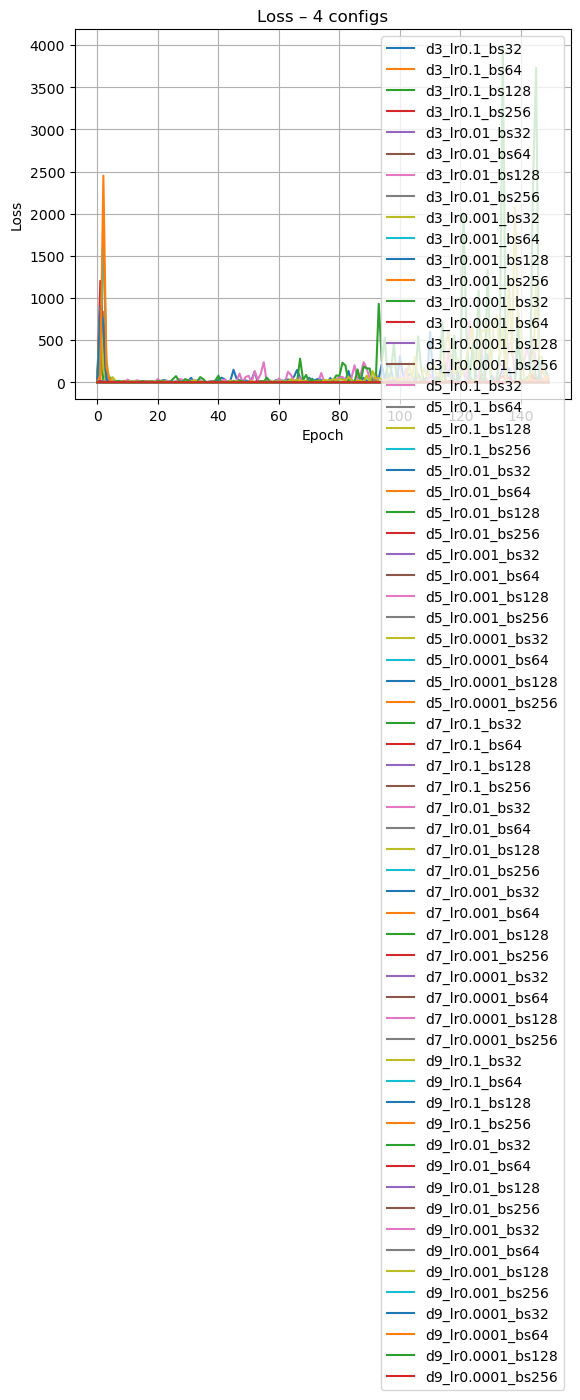

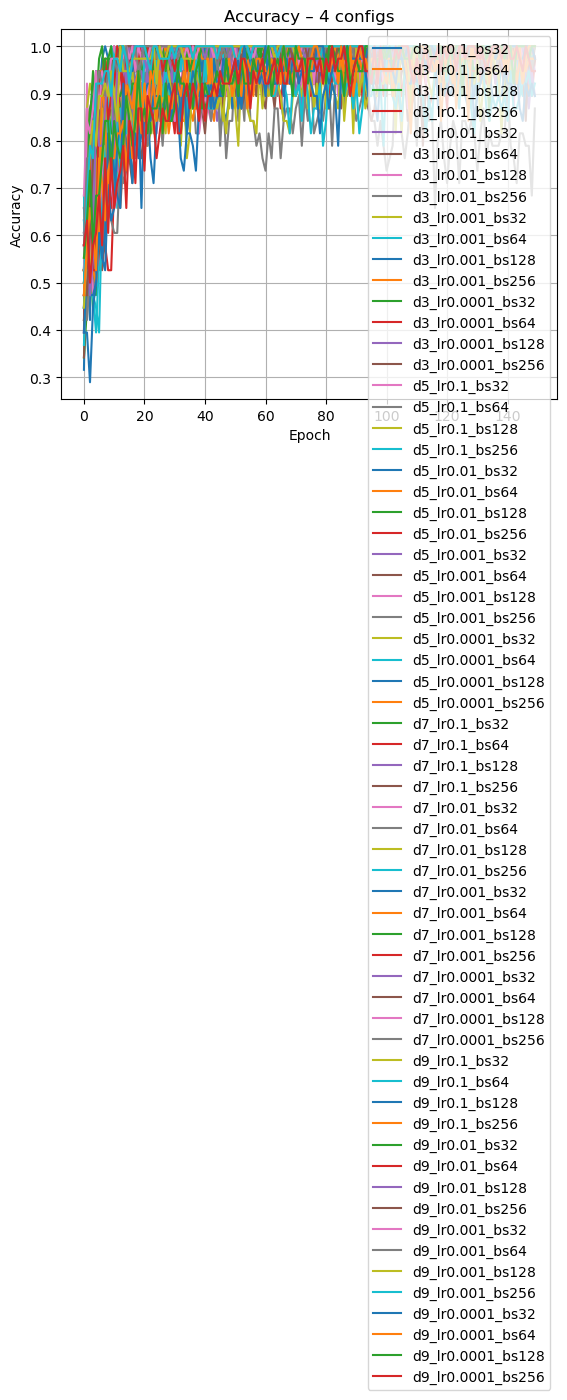

In [25]:
import matplotlib.pyplot as plt
# 1+2 plots
plt.figure(); 
plt.title("Loss – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.grid(); 
plt.show()

plt.figure(); 
plt.title("Accuracy – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['accuracy'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.grid(); 
plt.show()

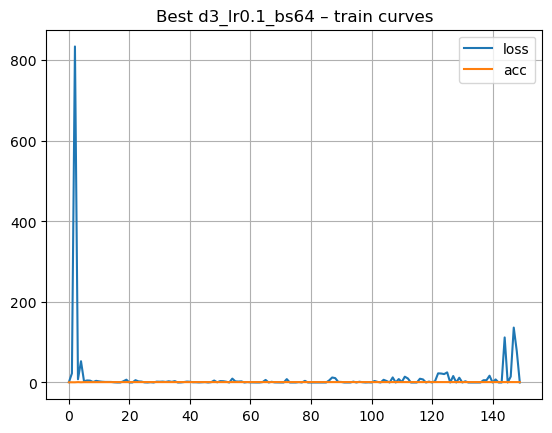

In [27]:
# 3 detailed curve for best
h=histories[best_key]
plt.figure(); 
plt.plot(h.history['loss'],label='loss'); 
plt.plot(h.history['accuracy'],label='acc')
plt.title(f"Best {best_key} – train curves"); 
plt.legend(); 
plt.grid(); 
plt.show()

In [29]:
slice_X, slice_y = [[] for _ in range(5)], [[] for _ in range(5)]

for subj, info in subject_dict.items():
    lbl  = info["label"]
    for i in range(5):
        slice_X[i].append(info["segments"][i+1])
        slice_y[i].append(lbl)

In [31]:
slice_X = [np.vstack(s) for s in slice_X]
slice_y = [np.array(s) for s in slice_y]

In [33]:
slice_X = [scaler.transform(s) for s in slice_X]

In [35]:

# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(best_model.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Slice 2‑th 5‑min  CM=[[16, 2], [0, 20]]  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
\nGLOBAL CM =\n [[16  2]
 [ 0 20]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Slice 3‑th 5‑min  CM=[[16, 2], [0, 20]]  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
\nGLOBAL CM =\n [[32  4]
 [ 0 40]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Slice 4‑th 5‑min  CM=[[16, 2], [0, 20]]  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
\nGLOBAL CM =\n [[48  6]
 [ 0 60]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Slice 5‑th 5‑min  CM=[[17, 1], [0, 20]]  Acc=0.974  Sens=1.000  Spec=0.944  Prec=0.952
\nGLOBAL CM =\n [[65  7]
 [ 0 80]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Slice 6‑th 5‑min  CM=[[17, 1], [1, 19]]  Acc=0.947  Sens=0.950  Spec=0.944  Prec=0.950
\nGLOBAL CM =\n [[82  8]
 [ 1 99]]


In [37]:
a1 = models['d3_lr0.01_bs256']
# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(a1.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 577ms/step
Slice 2‑th 5‑min  CM=[[17, 1], [0, 20]]  Acc=0.974  Sens=1.000  Spec=0.944  Prec=0.952
\nGLOBAL CM =\n [[17  1]
 [ 0 20]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Slice 3‑th 5‑min  CM=[[16, 2], [0, 20]]  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
\nGLOBAL CM =\n [[33  3]
 [ 0 40]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Slice 4‑th 5‑min  CM=[[17, 1], [1, 19]]  Acc=0.947  Sens=0.950  Spec=0.944  Prec=0.950
\nGLOBAL CM =\n [[50  4]
 [ 1 59]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Slice 5‑th 5‑min  CM=[[17, 1], [0, 20]]  Acc=0.974  Sens=1.000  Spec=0.944  Prec=0.952
\nGLOBAL CM =\n [[67  5]
 [ 1 79]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Slice 6‑th 5‑min  CM=[[16, 2], [1, 19]]  Acc=0.921  Sens=0.950  Spec=0.889  Prec=0.905
\nGLOBAL CM =\n [[83  7]
 [ 2 98]]


In [43]:
a2 = models['d9_lr0.01_bs32']
# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(a2.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Slice 2‑th 5‑min  CM=[[17, 1], [0, 20]]  Acc=0.9736842105263158  Sens=1.000  Spec=0.944  Prec=0.952
\nGLOBAL CM =\n [[17  1]
 [ 0 20]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Slice 3‑th 5‑min  CM=[[16, 2], [0, 20]]  Acc=0.9473684210526315  Sens=1.000  Spec=0.889  Prec=0.909
\nGLOBAL CM =\n [[33  3]
 [ 0 40]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Slice 4‑th 5‑min  CM=[[17, 1], [1, 19]]  Acc=0.9473684210526315  Sens=0.950  Spec=0.944  Prec=0.950
\nGLOBAL CM =\n [[50  4]
 [ 1 59]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Slice 5‑th 5‑min  CM=[[17, 1], [1, 19]]  Acc=0.9473684210526315  Sens=0.950  Spec=0.944  Prec=0.950
\nGLOBAL CM =\n [[67  5]
 [ 2 78]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Slice 6‑th 5‑min  CM=[[17, 1], [1, 19]]  Acc=0.9473684210526315  Sens=0.950  Spec=0.944  Prec=0.950
\nGLOBAL CM =\n [[84  6]
 [ 3 97]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


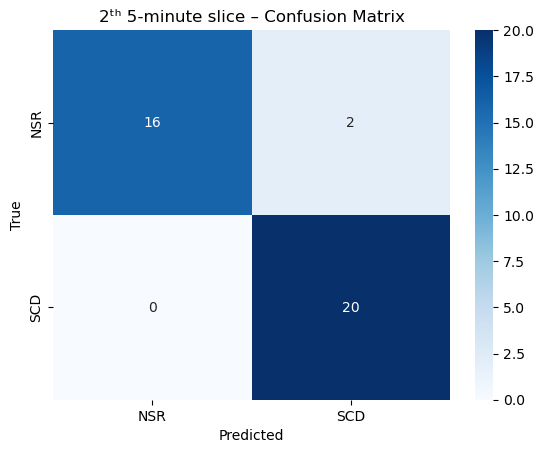

Slice 2:  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


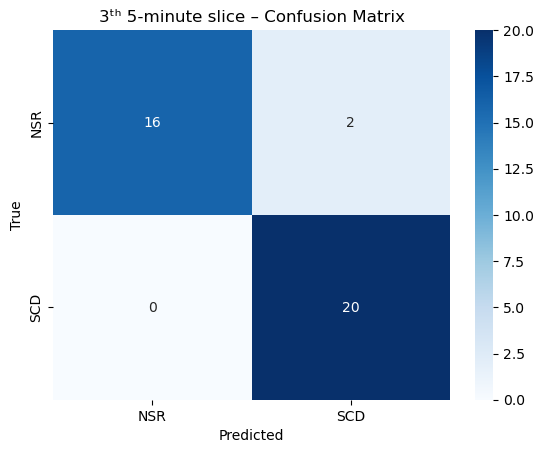

Slice 3:  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


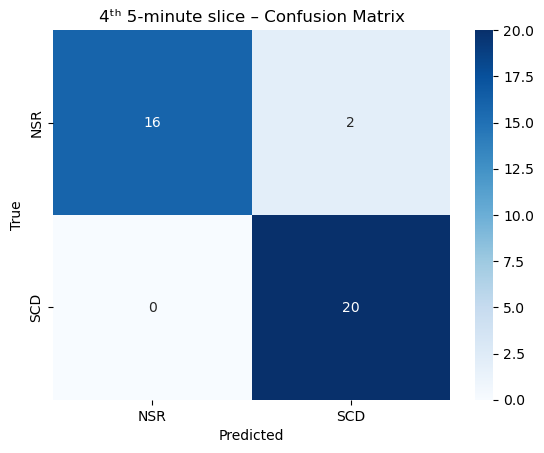

Slice 4:  Acc=0.947  Sens=1.000  Spec=0.889  Prec=0.909
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


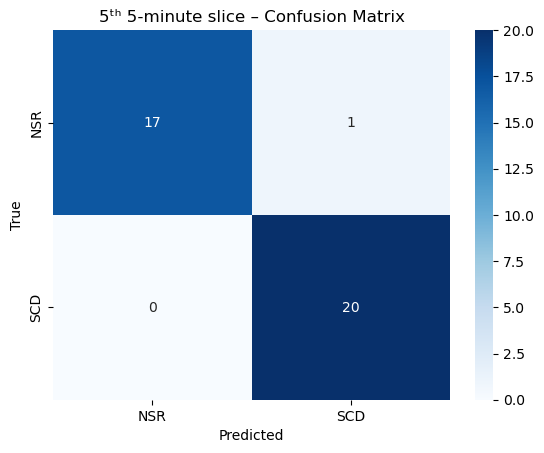

Slice 5:  Acc=0.974  Sens=1.000  Spec=0.944  Prec=0.952
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


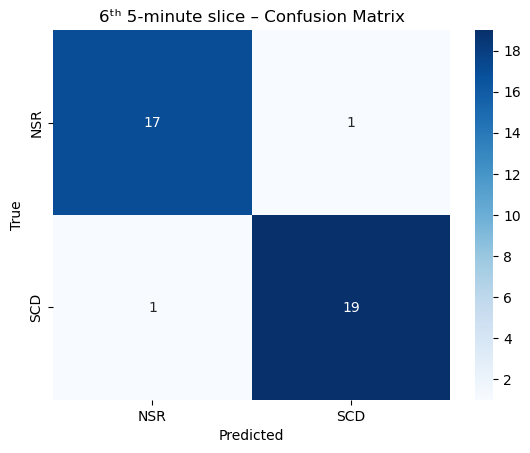

Slice 6:  Acc=0.947  Sens=0.950  Spec=0.944  Prec=0.950


In [45]:
import seaborn as sns
# ──────────────────────────────────────────
# ④ Slice‑wise confusion matrices (heat‑maps)
labels = ["NSR", "SCD"]
global_cm = np.zeros((2,2), int)

for idx, (X_s, y_s) in enumerate(zip(slice_X, slice_y), start=2):
    y_pred = (best_model.predict(X_s).ravel() >= 0.5).astype(int)
    cm = confusion_matrix(y_s, y_pred)
    global_cm += cm

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{idx}ᵗʰ 5‑minute slice – Confusion Matrix")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp+fn) else 0
    spec = tn / (tn + fp) if (tn+fp) else 0
    prec = tp / (tp + fp) if (tp+fp) else 0
    print(f"Slice {idx}:  Acc={acc:.3f}  Sens={sens:.3f}  "
          f"Spec={spec:.3f}  Prec={prec:.3f}")